# MMLU Benchmark

[Massive Multitask Language Understanding (MMLU)](https://github.com/hendrycks/test) is a popular benchmark for evaluating language models' world knowledge and problem solving abilities. The MMLU dataset contains 14,042 multiple choice questions (MCQs) from 57 categories including mathematics, history, biology, and business. Each question has 4 options (A, B, C, D) and one correct answer. In addition, each category includes 5 example questions designed for few shot experiments. When MMLU was first published in 2020, only the largest GPT models could do better than random guessing. By 2024, multiple models from OpenAI, Anthropic, Meta, and Tencent have all published MMLU accuracies over 88%.

Our goal is to approach Meta's published MMLU benchmark scores:

* MMLU of Llama 3.2 3B of 58% ([MODEL CARD](https://github.com/meta-llama/llama-models/blob/main/models/llama3_2/MODEL_CARD.md))

# Setup

In [1]:
import os
from pathlib import Path
from random import sample
from time import perf_counter_ns as timer

import jax
import rich
from rich.columns import Columns
from matplotlib import pyplot as plt
import numpy as np
from tqdm.auto import trange, tqdm
import seaborn as sns

import llama_jax as ll
from llama_jax.benchmarks.mmlu import (
    display_questions,
    download_dataset, 
    load_dataset,
    evaluate_generator,
    generate_prompt,
)

In [2]:
print(f"Available devices: {jax.devices()}")

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB

Available devices: [METAL(id=0)]


W0000 00:00:1740347988.195523  193355 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1740347988.207480  193355 service.cc:145] XLA service 0x12daf37f0 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740347988.207488  193355 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1740347988.208811  193355 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1740347988.208824  193355 mps_client.cc:384] XLA backend will use up to 51539214336 bytes on device 0 for SimpleAllocator.


In [3]:
# Configure
datasets_path = Path(os.environ["PROJECT_ROOT"]) / "build" / "datasets"
mmlu_dataset_path = datasets_path / "mmlu"

# Dataset

In [4]:
download_dataset(mmlu_dataset_path)

In [5]:
dataset = load_dataset(mmlu_dataset_path)
print(f"Loaded {len(dataset.questions)} questions, {len(dataset.examples)} examples, {len(dataset.categories)} categories")

Loaded 14042 questions, 285 examples, 57 categories


In [6]:
# Display sample
display_questions(dataset.questions)

,qid,category,question,A,B,C,D,answer
0,13157,public relations,"According to Esman (1972), which publics help ...",Enabling,Functional,Normative,Diffused,A
1,9615,nutrition,Water transport can occur from the lumen of th...,"A ""flip-flop"" mechanism efficiently transports...","Water flows into the gut from the mucosa, duri...",Water is mostly absorbed by movement between t...,Dietary intake of water is always greater than...,B
2,962,college chemistry,The dissociation energy for a hydrogen-bromine...,2 HBr(g) → H2(g) + Br2(l),HBr(g) → H+(g) + Br−(g),H(g) + Br(g) → HBr(g),HBr(g) → H(g) + Br(g),D
3,5945,high school world history,This question refers to the following informat...,The discovery of certain goods that the Chines...,Enlightenment revolutions in Europe and the Am...,The Industrial Revolution,The colonization of Africa,A
4,11361,professional law,"Farmer Fred was the owner of Grapeview Farm, t...","Insufficient, because it is too vague.","Sufficient, because it satisfies the title of ...","Sufficient, because the property can be identi...","Insufficient, because the gifts to the childre...",C


# Model

In [7]:
checkpoint = "Llama3.2-3B-Instruct"
max_tokens = 4096

In [8]:
config = ll.checkpoint.load_config(checkpoint, max_tokens=max_tokens)
params = ll.checkpoint.load_parameters(config)
model = ll.model.create(config, params)

In [9]:
sample_question = sample(dataset.questions, k=1)[0]

# Pre-compile model
generator = ll.benchmarks.mmlu.generator(config, model=model)
next(generator([sample_question]))

(Answer(qid=10806, expected='D', actual='A', scores={'A': 0.62890625, 'B': 0.08544921875, 'C': 0.0517578125, 'D': 0.2314453125}, correct=False),)

# Categories

Llama's MMLU score is reported in terms of macro_avg/acc_char. This means they calculate score for each category separately and then average them together.

In [10]:
categories = sorted(list(dataset.categories))

rich.print(Columns(categories))

abstract algebra             anatomy                   astronomy                          
business ethics              clinical knowledge        college biology                    
college chemistry            college computer science  college mathematics                
college medicine             college physics           computer security                  
conceptual physics           econometrics              electrical engineering             
elementary mathematics       formal logic              global facts                       
high school biology          high school chemistry     high school computer science       
high school european history high school geography     high school government and politics
high school macroeconomics   high school mathematics   high school microeconomics         
high school physics          high school psychology    high school statistics             
high school us history       high school world history human aging                        
human sexuality              international law         jurisprudence                      
logical fallacies            machine learning          management                         
marketing                    medical genetics          miscellaneous                      
moral disputes               moral scenarios           nutrition                          
philosophy                   prehistory                professional accounting            
professional law             professional medicine     professional psychology            
public relations             security studies          sociology                          
us foreign policy            virology                  world religions

In [11]:
n_categories = 10
selected_categories = sorted(sample(categories, k=n_categories))
rich.print(Columns(selected_categories))

# selected_categories = categories[:n_categories]

college biology     college computer science college physics econometrics     high school microeconomics
high school physics marketing                moral scenarios public relations us foreign policy

In [12]:
scoreboard = {}

# Zero Shot

In [13]:
# # Example of zero-shot prompt
# messages = generate_prompt(sample_question, n_shots=0, examples=dataset.examples)
# for m in messages:
#     rich.print(f"{m.role}\n\n{m.content}")

In [14]:
# Zero shot generator
generator = ll.benchmarks.mmlu.generator(config, model=model, n_shots=0)

In [15]:
scores = []
for category in tqdm(selected_categories, desc="Categories"):
    
    # Filter questions by category
    questions = [q for q in dataset.questions if q.category == category]
    progress = tqdm(total=len(questions), desc="Questions", leave=False)

    # Evaluate model
    score = evaluate_generator(generator, questions=questions, progress=progress)

    scores.append(score)

Categories:   0%|          | 0/10 [00:00<?, ?it/s]

Questions:   0%|          | 0/144 [00:00<?, ?it/s]

Questions:   0%|          | 0/100 [00:00<?, ?it/s]

Questions:   0%|          | 0/102 [00:00<?, ?it/s]

Questions:   0%|          | 0/114 [00:00<?, ?it/s]

Questions:   0%|          | 0/238 [00:00<?, ?it/s]

Questions:   0%|          | 0/151 [00:00<?, ?it/s]

Questions:   0%|          | 0/234 [00:00<?, ?it/s]

Questions:   0%|          | 0/895 [00:00<?, ?it/s]

Questions:   0%|          | 0/110 [00:00<?, ?it/s]

Questions:   0%|          | 0/100 [00:00<?, ?it/s]

<BarContainer object of 10 artists>

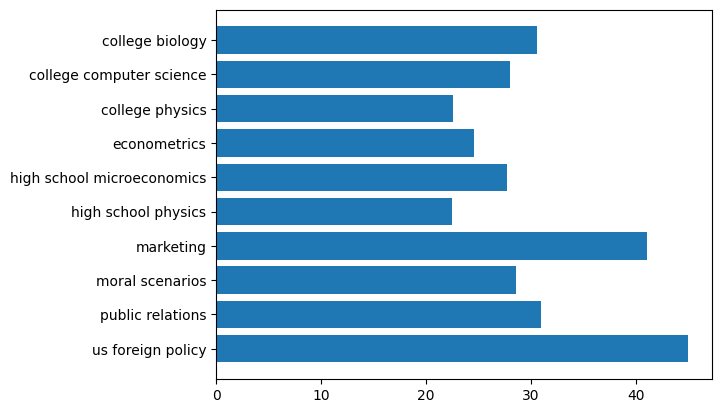

In [16]:
plt.barh(selected_categories[::-1], scores[::-1])

In [17]:
print(f"Avg score = {np.mean(scores):0.1f}")

Avg score = 30.1


In [18]:
scoreboard[0] = scores

# 3-Shot

In [19]:
# # Example of 3-shot prompt
# messages = generate_prompt(sample_question, n_shots=3, examples=dataset.examples)
# for m in messages:
#     rich.print(f"{m.role}\n\n{m.content}")

In [20]:
# 3-shot generator
generator = ll.benchmarks.mmlu.generator(config, model=model, n_shots=3, examples=dataset.examples)

In [21]:
scores = []
for category in tqdm(selected_categories, desc="Categories"):
    
    # Filter questions by category
    questions = [q for q in dataset.questions if q.category == category]
    progress = tqdm(total=len(questions), desc="Questions", leave=False)

    # Evaluate model
    score = evaluate_generator(generator, questions=questions, progress=progress)

    scores.append(score)

Categories:   0%|          | 0/10 [00:00<?, ?it/s]

Questions:   0%|          | 0/144 [00:00<?, ?it/s]

Questions:   0%|          | 0/100 [00:00<?, ?it/s]

Questions:   0%|          | 0/102 [00:00<?, ?it/s]

Questions:   0%|          | 0/114 [00:00<?, ?it/s]

Questions:   0%|          | 0/238 [00:00<?, ?it/s]

Questions:   0%|          | 0/151 [00:00<?, ?it/s]

Questions:   0%|          | 0/234 [00:00<?, ?it/s]

Questions:   0%|          | 0/895 [00:00<?, ?it/s]

Questions:   0%|          | 0/110 [00:00<?, ?it/s]

Questions:   0%|          | 0/100 [00:00<?, ?it/s]

<BarContainer object of 10 artists>

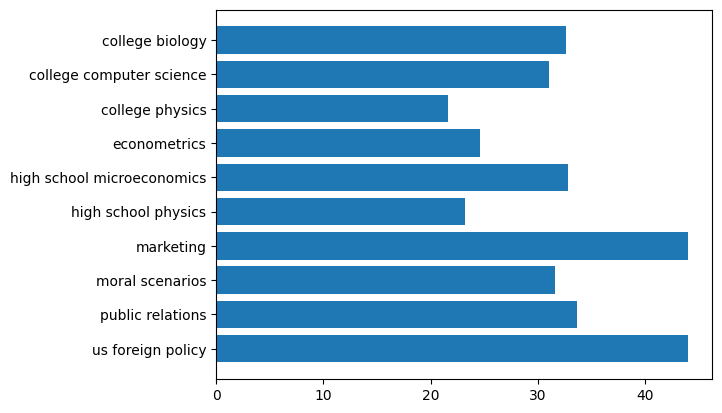

In [22]:
plt.barh(selected_categories[::-1], scores[::-1])

In [23]:
print(f"Avg score = {np.mean(scores):0.1f}")

Avg score = 31.9


In [24]:
scoreboard[3] = scores

# 5-Shot

In [25]:
# # Example of 5-shot prompt
# messages = generate_prompt(sample_question, n_shots=5, examples=dataset.examples)
# for m in messages:
#     rich.print(f"{m.role}\n\n{m.content}")

In [26]:
# 5-shot generator
generator = ll.benchmarks.mmlu.generator(config, model=model, n_shots=5, examples=dataset.examples)

In [27]:
scores = []
for category in tqdm(selected_categories, desc="Categories"):
    
    # Filter questions by category
    questions = [q for q in dataset.questions if q.category == category]
    progress = tqdm(total=len(questions), desc="Questions", leave=False)

    # Evaluate model
    score = evaluate_generator(generator, questions=questions, progress=progress)

    scores.append(score)

Categories:   0%|          | 0/10 [00:00<?, ?it/s]

Questions:   0%|          | 0/144 [00:00<?, ?it/s]

Questions:   0%|          | 0/100 [00:00<?, ?it/s]

Questions:   0%|          | 0/102 [00:00<?, ?it/s]

Questions:   0%|          | 0/114 [00:00<?, ?it/s]

Questions:   0%|          | 0/238 [00:00<?, ?it/s]

Questions:   0%|          | 0/151 [00:00<?, ?it/s]

Questions:   0%|          | 0/234 [00:00<?, ?it/s]

Questions:   0%|          | 0/895 [00:00<?, ?it/s]

Questions:   0%|          | 0/110 [00:00<?, ?it/s]

Questions:   0%|          | 0/100 [00:00<?, ?it/s]

<BarContainer object of 10 artists>

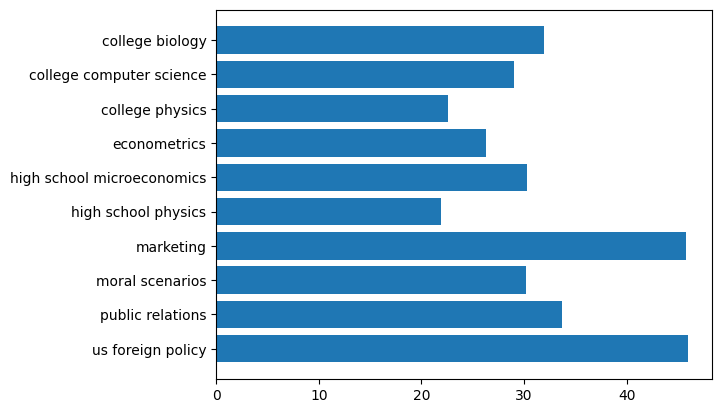

In [28]:
plt.barh(selected_categories[::-1], scores[::-1])

In [29]:
print(f"Avg score = {np.mean(scores):0.1f}")

Avg score = 31.7


In [30]:
scoreboard[5] = scores

In [32]:
scoreboard

{0: [30.555555555555557,
  28.0,
  22.54901960784314,
  24.56140350877193,
  27.73109243697479,
  22.516556291390728,
  41.02564102564103,
  28.60335195530726,
  30.90909090909091,
  45.0],
 3: [32.638888888888886,
  31.0,
  21.568627450980394,
  24.56140350877193,
  32.773109243697476,
  23.178807947019866,
  44.01709401709402,
  31.620111731843576,
  33.63636363636363,
  44.0],
 5: [31.944444444444443,
  29.0,
  22.54901960784314,
  26.31578947368421,
  30.252100840336134,
  21.85430463576159,
  45.72649572649573,
  30.16759776536313,
  33.63636363636363,
  46.0]}

# Analysis

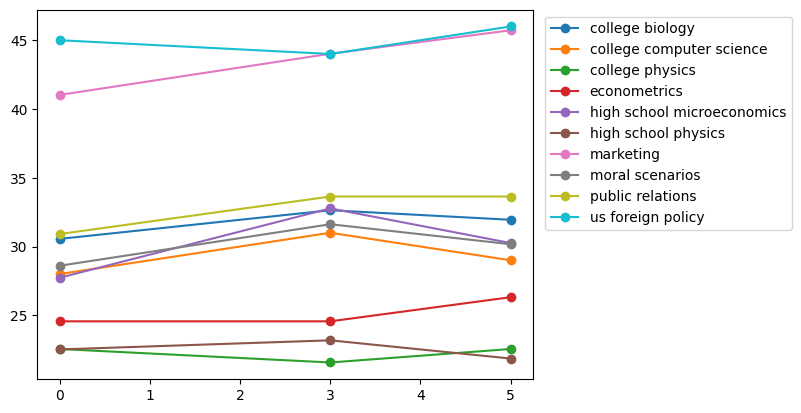

In [33]:
fig, ax = plt.subplots()

shots = [0, 3, 5]

for i, category in enumerate(selected_categories):
    scores = [scoreboard[s][i] for s in shots]
    ax.plot(shots, scores, marker="o", label=category)

plt.legend(bbox_to_anchor=(1.01, 1), loc="upper left")